# A minimal example of creating a custom LJ potential with WCA perturbation
This notebook shows an example of moving the LJ potential from `NonbondedForce` to `CustomNonbondedForce` for a butane molecule in vacuum. The parameters for the molecule are obtained from GAFF.

In [1]:
from simtk.openmm.app import *
from simtk.openmm import *
import simtk.unit as unit
import numpy as np
import matplotlib.pyplot as plt
from MDAnalysis.coordinates.DCD import DCDFile

## Load Amber topology and create OpenMM System

In [2]:
prmtop = AmberPrmtopFile('butane.prmtop')
inpcrd = AmberInpcrdFile('butane.rst7')

In [3]:
system = prmtop.createSystem(
    nonbondedMethod=NoCutoff,
    constraints=HBonds,
)
forces = {system.getForce(index).__class__.__name__: system.getForce(index) for index in range(system.getNumForces())}
nonbonded_force = forces['NonbondedForce']

## Calculate the potential energy with the current LJ

In [6]:
integrator = LangevinIntegrator(298.15 * unit.kelvin, 1.0 / unit.picoseconds, 2.0 * unit.femtosecond)
simulation = Simulation(
    prmtop.topology, 
    system, 
    integrator,
    openmm.Platform.getPlatformByName('CPU'),
)
simulation.context.setPositions(inpcrd.positions)

In [7]:
total_energy = simulation.context.getState(getEnergy=True, groups={0})
energy_original = total_energy.getPotentialEnergy() / unit.kilocalorie_per_mole

Potential over trajectories

In [8]:
potential_energy = {"nonbonded": [], "custom": []}

In [9]:
with DCDFile("thermalisation.dcd") as dcd:
    header = dcd.header

    for xyz, box in zip(dcd.readframes()[0], dcd.readframes()[1]):        
        simulation.context.setPositions(xyz * unit.angstrom)
        
        lennard_jones = simulation.context.getState(getEnergy=True, groups={0})
        lennard_jones = lennard_jones.getPotentialEnergy() / unit.kilocalories_per_mole

        potential_energy["nonbonded"].append(lennard_jones)

potential_energy["nonbonded"] = np.array(potential_energy["nonbonded"])

## Create new CustomNonbondedForce
Example here is to replace the 12-6 LJ potential in `NonbondedForce` and move it to `CustomNonbondedForce`.

In [10]:
def add_custom_LJ(system):
    nonbonded = [force for force in system.getForces() if isinstance(force, NonbondedForce)][0]
    
    LJ_potential = "4*epsilon*((sigma/r)^12-(sigma/r)^6); "
    Lorentz_Berthelot = "sigma=0.5*(sigma1+sigma2); epsilon=sqrt(epsilon1*epsilon2)"
    
    LJ_new = CustomNonbondedForce(LJ_potential + Lorentz_Berthelot)
    LJ_new.addPerParticleParameter("sigma")
    LJ_new.addPerParticleParameter("epsilon")
    LJ_new.setNonbondedMethod(CustomNonbondedForce.NoCutoff)

    # Set LJ parameters
    for atom in range(nonbonded.getNumParticles()):
        [charge, sigma, epsilon] = nonbonded.getParticleParameters(atom)
        LJ_new.addParticle([sigma, epsilon])

    # Transfer Exclusion
    for exception_index in range(nonbonded.getNumExceptions()):
        iatom, jatom, chargeprod, sigma, epsilon = nonbonded.getExceptionParameters(exception_index)
        LJ_new.addExclusion(iatom, jatom)

    system.addForce(LJ_new)

In [11]:
def add_wca_repulsive(system, lambda_value=1.0):
    nonbonded = [force for force in system.getForces() if isinstance(force, NonbondedForce)][0]
    
    wca_repulsive = CustomNonbondedForce(
        "step(2^(1/6)*sigma - r) * U_sterics;"
        "U_sterics=(lambda^softcore_a)*(4*epsilon*x*(x-1.0) + epsilon);"
        "x=(sigma/reff_sterics)^6;"
        "reff_sterics=sigma*((softcore_alpha*(1.0 - lambda)^softcore_b + (r/sigma)^softcore_c))^(1/softcore_c);"
        "sigma=0.5*(sigma1+sigma2);"
        "epsilon=sqrt(epsilon1*epsilon2)"
    )
    wca_repulsive.addGlobalParameter("lambda", lambda_value)
    wca_repulsive.addGlobalParameter("softcore_alpha", 0.5)
    wca_repulsive.addGlobalParameter("softcore_a", 1)
    wca_repulsive.addGlobalParameter("softcore_b", 1)
    wca_repulsive.addGlobalParameter("softcore_c", 6)
    wca_repulsive.addEnergyParameterDerivative("lambda")
    wca_repulsive.addPerParticleParameter("sigma")
    wca_repulsive.addPerParticleParameter("epsilon")
    wca_repulsive.setNonbondedMethod(CustomNonbondedForce.CutoffPeriodic)
    wca_repulsive.setCutoffDistance(nonbonded.getCutoffDistance())
    wca_repulsive.setUseLongRangeCorrection(nonbonded.getUseDispersionCorrection())

    # Set LJ parameters
    for atom in range(nonbonded.getNumParticles()):
        wca_repulsive.addParticle(nonbonded.getParticleParameters(atom)[1:])

    # Transfer Exclusion
    for exception_index in range(nonbonded.getNumExceptions()):
        iatom, jatom, chargeprod, sigma, epsilon = nonbonded.getExceptionParameters(exception_index)
        wca_repulsive.addExclusion(iatom, jatom)

    system.addForce(wca_repulsive)

In [12]:
def add_wca_dispersive(system, lambda_value=1.0):
    nonbonded = [force for force in system.getForces() if isinstance(force, NonbondedForce)][0]
    
    wca_dispersive = CustomNonbondedForce(
        "(step(2^(1/6)*sigma - r) * -1*epsilon) + (step(r - 2^(1/6)*sigma) * U_sterics);"
        "U_sterics=(lambda^softcore_a)*4*epsilon*x*(x-1.0);"
        "x=(sigma/reff_sterics)^6;"
        "reff_sterics=sigma*((softcore_alpha*(1.0 - lambda)^softcore_b + (r/sigma)^softcore_c))^(1/softcore_c);"
        "sigma=0.5*(sigma1+sigma2);"
        "epsilon=sqrt(epsilon1*epsilon2)"
    )
    wca_dispersive.addGlobalParameter("lambda", lambda_value)
    wca_dispersive.addGlobalParameter("softcore_alpha", 0.5)
    wca_dispersive.addGlobalParameter("softcore_a", 1)
    wca_dispersive.addGlobalParameter("softcore_b", 1)
    wca_dispersive.addGlobalParameter("softcore_c", 6)
    wca_dispersive.addEnergyParameterDerivative("lambda")
    wca_dispersive.addPerParticleParameter("sigma")
    wca_dispersive.addPerParticleParameter("epsilon")
    wca_dispersive.setNonbondedMethod(CustomNonbondedForce.CutoffPeriodic)
    wca_dispersive.setCutoffDistance(nonbonded.getCutoffDistance())
    wca_dispersive.setUseLongRangeCorrection(nonbonded.getUseDispersionCorrection())

    # Set LJ parameters
    for atom in range(nonbonded.getNumParticles()):
        wca_dispersive.addParticle(nonbonded.getParticleParameters(atom)[1:])

    # Transfer Exclusion
    for exception_index in range(nonbonded.getNumExceptions()):
        iatom, jatom, chargeprod, sigma, epsilon = nonbonded.getExceptionParameters(exception_index)
        wca_dispersive.addExclusion(iatom, jatom)

    system.addForce(wca_dispersive)

In [13]:
# add_custom_LJ(system)
add_wca_repulsive(system)
add_wca_dispersive(system)

## Set LJ parameters in `NonbondedForce` to Zero
Since we only want `CustomNonbondedForce` to take care of the LJ potential

In [14]:
for atom in range(system.getNumParticles()):
    current_parameters = nonbonded_force.getParticleParameters(atom)
    nonbonded_force.setParticleParameters(atom, current_parameters[0], 0.0, 0.0)

## Calculate the energy with the new LJ

In [15]:
integrator = LangevinIntegrator(298.15 * unit.kelvin, 1.0 / unit.picoseconds, 2.0 * unit.femtosecond)
simulation = Simulation(
    prmtop.topology, 
    system, 
    integrator,
    openmm.Platform.getPlatformByName('CPU'),
)
simulation.context.setPositions(inpcrd.positions)

In [16]:
total_energy = simulation.context.getState(getEnergy=True, groups={0})
energy_custom = total_energy.getPotentialEnergy() / unit.kilocalorie_per_mole

Potential over trajectories

In [17]:
with DCDFile("thermalisation.dcd") as dcd:
    header = dcd.header

    for xyz, box in zip(dcd.readframes()[0], dcd.readframes()[1]):        
        simulation.context.setPositions(xyz * unit.angstrom)
        
        lennard_jones = simulation.context.getState(getEnergy=True, groups={0})
        lennard_jones = lennard_jones.getPotentialEnergy() / unit.kilocalories_per_mole

        potential_energy["custom"].append(lennard_jones)

potential_energy["custom"] = np.array(potential_energy["custom"])

## Compare Energies

In [18]:
print("Total energy of butane:")
print(f" - Original = {energy_original:.5f} kcal/mol")
print(f" - Custom   = {energy_custom:.5f} kcal/mol")

Total energy of butane:
 - Original = 2.30706 kcal/mol
 - Custom   = 2.30070 kcal/mol


Text(0.5, 0, 'Frames')

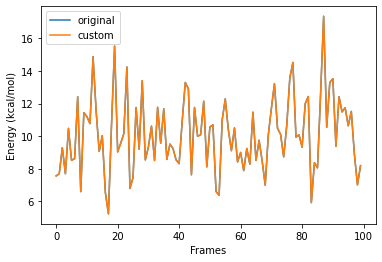

In [19]:
plt.plot(potential_energy["nonbonded"], label="original")
plt.plot(potential_energy["custom"], label="custom")
plt.legend()
plt.ylabel("Energy (kcal/mol)")
plt.xlabel("Frames")